In [27]:
import torch
import torch.nn.functional as F
import random
import matplotlib.pyplot as plt

In [28]:
with open("names.txt", "r") as f:
    words = f.read().splitlines()
chars = ["."] + sorted(list(set("".join(words))))
stoi = {c: i for i, c in enumerate(chars)}
itos = {i: c for i, c in enumerate(chars)}
block_size = 3
vocab_size = len(itos)
embedding_size = 10
hidden_size = 200

In [29]:
def build_dataset(words, block_size):
    X, y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + ".":
            ix = stoi[ch]
            X.append(context)
            y.append(ix)
            context = context[1:] + [ix]
    return torch.tensor(X), torch.tensor(y)


def split_dataset(words):
    random.seed(42)
    random.shuffle(words)
    n1 = int(0.8 * len(words))
    n2 = int(0.9 * len(words))
    train = words[:n1]
    dev = words[n1:n2]
    test = words[n2:]
    X_train, y_train = build_dataset(train, block_size)
    X_dev, y_dev = build_dataset(dev, block_size)
    X_test, y_test = build_dataset(test, block_size)
    return X_train, y_train, X_dev, y_dev, X_test, y_test


X_train, y_train, X_dev, y_dev, X_test, y_test = split_dataset(words)

In [30]:
gain = 5 / 3
fan_in = block_size * embedding_size
g = torch.Generator().manual_seed(42)
C = torch.randn((vocab_size, embedding_size), generator=g)
W1 = (
    torch.randn((block_size * embedding_size, hidden_size), generator=g)
    * gain
    / (fan_in**0.5)
)
# b1 = torch.randn(hidden_size, generator=g) * 0.01
W2 = torch.randn((hidden_size, vocab_size), generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0

bngain = torch.ones((1, hidden_size))
bnbias = torch.zeros((1, hidden_size))
bnmean_running = torch.zeros((1, hidden_size))
bnstd_running = torch.ones((1, hidden_size))
parameters = [C, W1, W2, b2, bngain, bnbias]
for p in parameters:
    p.requires_grad = True

In [31]:
max_steps = 200000
batch_size = 32
lossi = []
for i in range(max_steps):
    ix = torch.randint(0, len(X_train), (batch_size,))
    Xb, yb = X_train[ix], y_train[ix]
    emb = C[Xb]
    emb_cat = emb.view(-1, block_size * embedding_size)
    hpreact = emb_cat @ W1
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias
    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, yb)
    for p in parameters:
        p.grad = None
    loss.backward()
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data -= lr * p.grad

    if i % 10000 == 0:
        print(f"{i} / {max_steps}, loss: {loss.item()}")
    lossi.append(loss.log10().item())

0 / 200000, loss: 3.310149908065796
10000 / 200000, loss: 2.3962700366973877
20000 / 200000, loss: 1.877697229385376
30000 / 200000, loss: 2.5069961547851562
40000 / 200000, loss: 2.4665608406066895
50000 / 200000, loss: 2.8462395668029785
60000 / 200000, loss: 2.347097635269165
70000 / 200000, loss: 2.6181657314300537
80000 / 200000, loss: 2.121211290359497
90000 / 200000, loss: 1.974596619606018
100000 / 200000, loss: 1.7386584281921387
110000 / 200000, loss: 2.1148171424865723
120000 / 200000, loss: 2.0662293434143066
130000 / 200000, loss: 2.1388766765594482
140000 / 200000, loss: 2.3768527507781982
150000 / 200000, loss: 2.1260907649993896
160000 / 200000, loss: 2.2178776264190674
170000 / 200000, loss: 1.618735909461975
180000 / 200000, loss: 2.1766862869262695
190000 / 200000, loss: 2.266955852508545


(array([436., 255., 173., 160., 118., 114., 122., 117., 111., 101.,  93.,
        100.,  75.,  92., 112.,  91.,  92.,  73., 115., 111.,  93.,  96.,
        101., 122., 122.,  95., 103., 101.,  95., 100., 107.,  85.,  70.,
        115.,  95.,  76.,  95.,  83., 107., 116.,  97., 121., 113., 121.,
        133., 117., 175., 202., 232., 451.]),
 array([-9.99987841e-01, -9.59988618e-01, -9.19989395e-01, -8.79990172e-01,
        -8.39990950e-01, -7.99991727e-01, -7.59992504e-01, -7.19993281e-01,
        -6.79994059e-01, -6.39994836e-01, -5.99995613e-01, -5.59996390e-01,
        -5.19997168e-01, -4.79997945e-01, -4.39998722e-01, -3.99999499e-01,
        -3.60000277e-01, -3.20001054e-01, -2.80001831e-01, -2.40002608e-01,
        -2.00003386e-01, -1.60004163e-01, -1.20004940e-01, -8.00057173e-02,
        -4.00064945e-02, -7.27176666e-06,  3.99919510e-02,  7.99911737e-02,
         1.19990396e-01,  1.59989619e-01,  1.99988842e-01,  2.39988065e-01,
         2.79987288e-01,  3.19986510e-01,  3.59985

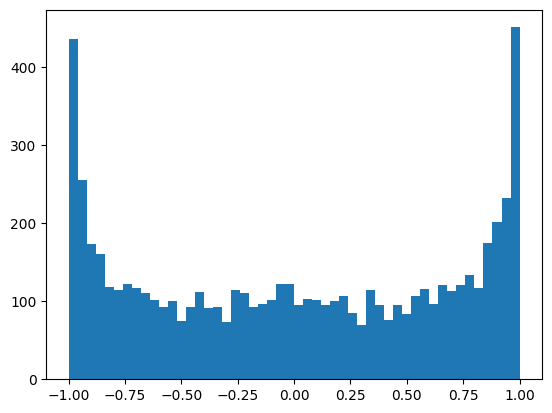

In [32]:
plt.hist(h.view(-1).tolist(), bins=50)

(array([  1.,   0.,   1.,   2.,   1.,   3.,   6.,   6.,   6.,   7.,  18.,
         19.,  38.,  35.,  51.,  85.,  98., 131., 182., 188., 230., 296.,
        349., 412., 513., 603., 558., 443., 418., 351., 263., 252., 203.,
        149., 119.,  98.,  83.,  50.,  45.,  30.,  22.,  11.,   9.,   9.,
          3.,   0.,   0.,   0.,   1.,   2.]),
 array([-6.00614548, -5.77379157, -5.54143766, -5.30908376, -5.07672985,
        -4.84437594, -4.61202204, -4.37966813, -4.14731422, -3.91496032,
        -3.68260641, -3.4502525 , -3.2178986 , -2.98554469, -2.75319078,
        -2.52083688, -2.28848297, -2.05612906, -1.82377516, -1.59142125,
        -1.35906734, -1.12671344, -0.89435953, -0.66200562, -0.42965172,
        -0.19729781,  0.0350561 ,  0.26741   ,  0.49976391,  0.73211782,
         0.96447172,  1.19682563,  1.42917953,  1.66153344,  1.89388735,
         2.12624125,  2.35859516,  2.59094907,  2.82330297,  3.05565688,
         3.28801079,  3.52036469,  3.7527186 ,  3.98507251,  4.21742641,
 

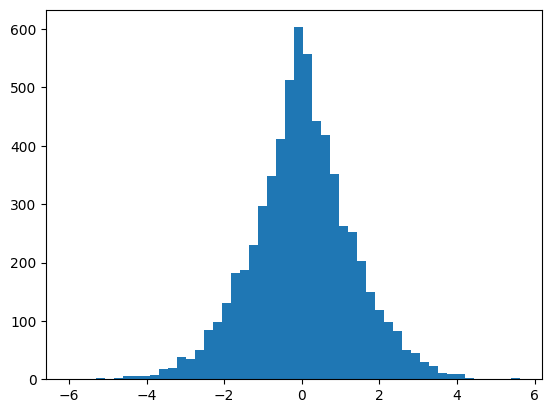

In [33]:
plt.hist(hpreact.view(-1).tolist(), bins=50)

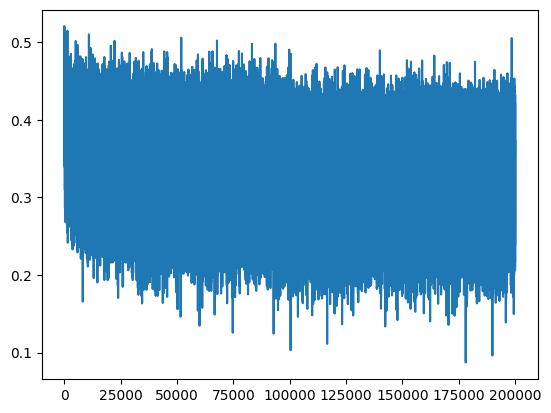

In [34]:
plt.plot(lossi)

In [35]:
@torch.no_grad()
def split_loss(split):
    X, y = {
        "train": (X_train, y_train),
        "val": (X_dev, y_dev),
        "test": (X_test, y_test),
    }[split]
    emb = C[X]
    emb_cat = emb.view(-1, block_size * embedding_size)
    hpreact = emb_cat @ W1
    hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())


split_loss("train")
split_loss("val")

train 2.069705009460449
val 2.1122283935546875


In [36]:
# sample from the model
g = torch.Generator().manual_seed(10)

for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor(context)]
        h = torch.tanh(emb.view(1, -1) @ W1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]

        out.append(ix)
        if ix == 0:
            break
    print("".join(itos[i] for i in out))

propehquilliyaden.
natomrickecchavdys.
qlingtobajleemcimbyshameddh.
tralynorbaellareliyadha.
fththandru.
zthundin.
tom.
ssfaniyumnessidyn.
zhamdyliah.
faiushmaraldwissaharaidee.
thren.
brynje.
frigh.
kmikh.
tailandwgnrecklahimadifohfaamphneolaubryna.
trunsbhnord.
mctieustissafnakhilynadellenet.
qzviyton.
tallamrighsequadnurdaydershmib.
prav.


In [37]:
# SUMMARY + PYTORCHIFYING -----------

In [38]:
class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = (
            torch.randn(fan_in, fan_out, generator=g) * gain / (fan_in**0.5)
        )
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers (trained with a runnning 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        if self.training:
            xmean = x.mean(0, keepdim=True)
            xvar = x.var(0, keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta
        if self.training:
            self.running_mean = (
                1 - self.momentum
            ) * self.running_mean + self.momentum * xmean
            self.running_var = (
                1 - self.momentum
            ) * self.running_var + self.momentum * xvar

        return self.out

    def parameters(self):
        return [self.gamma, self.beta]


class Tanh:
    def __call__(self, x):
        self.out = x.tanh()
        return self.out

    def parameters(self):
        return []


vocab_size = len(itos)
n_embed = 10
n_hidden = 100
g = torch.Generator().manual_seed(42)
C = torch.randn((vocab_size, n_embed), generator=g)
layers = [
    Linear(n_embed * block_size, n_hidden, bias=False),
    BatchNorm1d(n_hidden),
    Tanh(),
    Linear(n_hidden, n_hidden, bias=False),
    BatchNorm1d(n_hidden),
    Tanh(),
    Linear(n_hidden, n_hidden, bias=False),
    BatchNorm1d(n_hidden),
    Tanh(),
    Linear(n_hidden, n_hidden, bias=False),
    BatchNorm1d(n_hidden),
    Tanh(),
    Linear(n_hidden, n_hidden, bias=False),
    BatchNorm1d(n_hidden),
    Tanh(),
    Linear(n_hidden, vocab_size, bias=False),
    BatchNorm1d(vocab_size),
]
with torch.no_grad():
    layers[-1].gamma *= 0.1
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 1.0
parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

47024


In [39]:
max_steps = 200000
batch_size = 32
lossi = []
ud = []
for i in range(max_steps):
    # construct a batch
    ix = torch.randint(0, len(X_train), (batch_size,), generator=g)
    Xbatch, Ybatch = X_train[ix], y_train[ix]
    # forward
    emb = C[Xbatch]
    x = emb.view(emb.shape[0], -1)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Ybatch)
    # backward
    for layer in layers:
        layer.out.retain_grad()
    for p in parameters:
        p.grad = None
    loss.backward()
    # update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data -= lr * p.grad
    # track stats
    if i % 10000 == 0:
        print(f"{i:7d}/{max_steps}, loss: {loss.item()}")
    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append(
            [
                ((lr * p.grad).std() / p.data.std()).log10().item()
                for p in parameters
            ]
        )

      0/200000, loss: 3.2998499870300293


  10000/200000, loss: 2.182713270187378
  20000/200000, loss: 1.8912798166275024
  30000/200000, loss: 1.9998688697814941
  40000/200000, loss: 2.2823102474212646
  50000/200000, loss: 2.008711099624634
  60000/200000, loss: 2.1466588973999023
  70000/200000, loss: 2.173495292663574
  80000/200000, loss: 1.6837408542633057
  90000/200000, loss: 2.357351541519165
 100000/200000, loss: 1.9120666980743408
 110000/200000, loss: 2.0294907093048096
 120000/200000, loss: 2.154614210128784
 130000/200000, loss: 2.1732048988342285
 140000/200000, loss: 2.1761584281921387
 150000/200000, loss: 2.1261839866638184
 160000/200000, loss: 2.4700331687927246
 170000/200000, loss: 2.0350377559661865
 180000/200000, loss: 1.780609369277954
 190000/200000, loss: 2.1573829650878906


layer 2 (      Tanh): mean -0.03, std 0.70, saturated: 14.22%
layer 5 (      Tanh): mean -0.01, std 0.73, saturated: 16.50%
layer 8 (      Tanh): mean +0.00, std 0.74, saturated: 17.19%
layer 11 (      Tanh): mean +0.01, std 0.75, saturated: 16.59%
layer 14 (      Tanh): mean +0.02, std 0.76, saturated: 19.22%


Text(0.5, 1.0, 'Activation distribution')

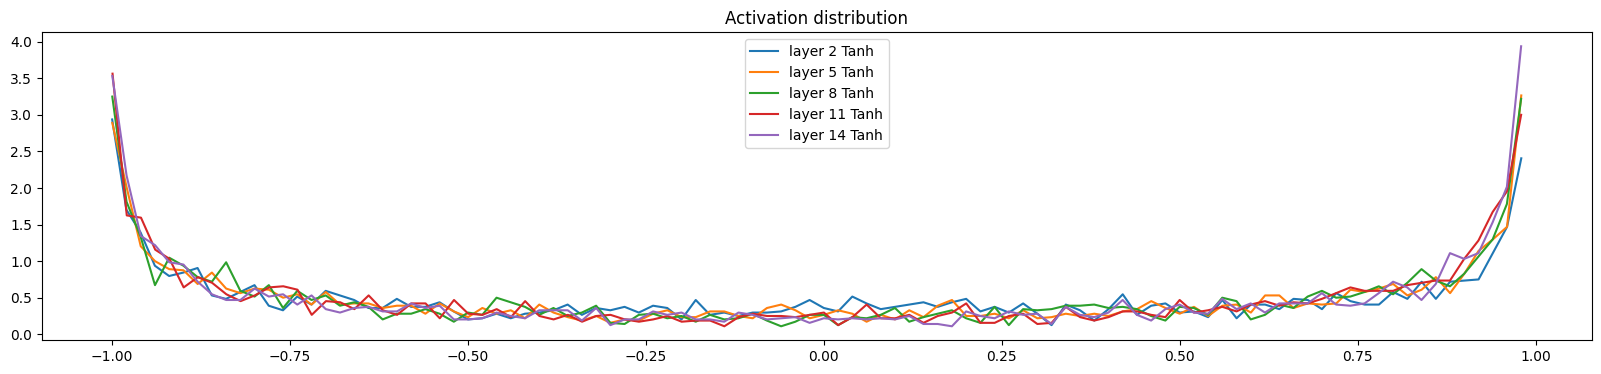

In [40]:
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers):
    if isinstance(layer, Tanh):
        t = layer.out
        print(
            "layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%"
            % (
                i,
                layer.__class__.__name__,
                t.mean(),
                t.std(),
                (t.abs() > 0.97).float().mean() * 100,
            )
        )
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"layer {i} {layer.__class__.__name__}")
plt.legend(legends)
plt.title("Activation distribution")

layer 2 (      Tanh): mean +0.000000, std 3.889006e-03
layer 5 (      Tanh): mean +0.000000, std 3.777469e-03
layer 8 (      Tanh): mean +0.000000, std 3.607363e-03
layer 11 (      Tanh): mean -0.000000, std 3.662286e-03
layer 14 (      Tanh): mean +0.000000, std 3.309795e-03


Text(0.5, 1.0, 'gradient distribution')

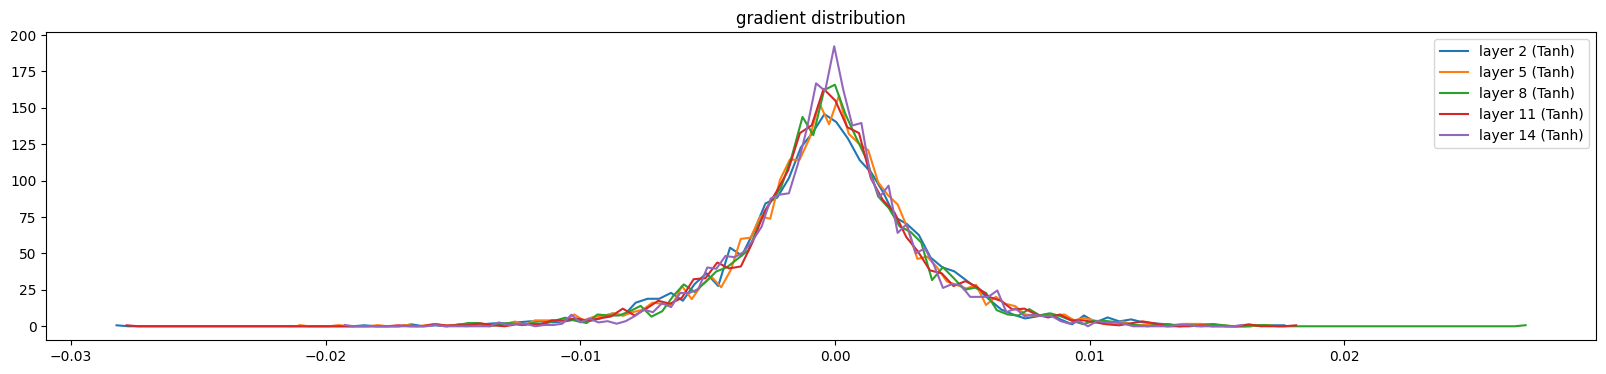

In [41]:
import matplotlib.pyplot as plt
import torch

plt.figure(figsize=(20, 4))  # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]):  # note: exclude the output layer
    if isinstance(layer, Tanh):
        t = layer.out.grad
        if t is not None:
            print(
                "layer %d (%10s): mean %+f, std %e"
                % (i, layer.__class__.__name__, t.mean(), t.std())
            )
            hy, hx = torch.histogram(t, density=True)
            plt.plot(hx[:-1].detach(), hy.detach())
            legends.append(f"layer {i} ({layer.__class__.__name__})")
        else:
            print(
                f"layer {i:>10} ({layer.__class__.__name__:>10}) has no gradient"
            )
plt.legend(legends)
plt.title("gradient distribution")

weight:        (27, 10) | mean:  -0.000000 | std: 1.255377e-02 | grad:data ratio: 1.152643e-02
weight:       (30, 100) | mean:  -0.000097 | std: 7.857828e-03 | grad:data ratio: 1.919189e-02
weight:      (100, 100) | mean:  -0.000061 | std: 5.813052e-03 | grad:data ratio: 2.364549e-02
weight:      (100, 100) | mean:   0.000041 | std: 5.792045e-03 | grad:data ratio: 2.397615e-02
weight:      (100, 100) | mean:  -0.000074 | std: 5.506815e-03 | grad:data ratio: 2.340794e-02
weight:      (100, 100) | mean:  -0.000037 | std: 5.196914e-03 | grad:data ratio: 2.273769e-02
weight:       (100, 27) | mean:   0.000078 | std: 7.813034e-03 | grad:data ratio: 2.378235e-02


Text(0.5, 1.0, 'Weights Gradient distribution')

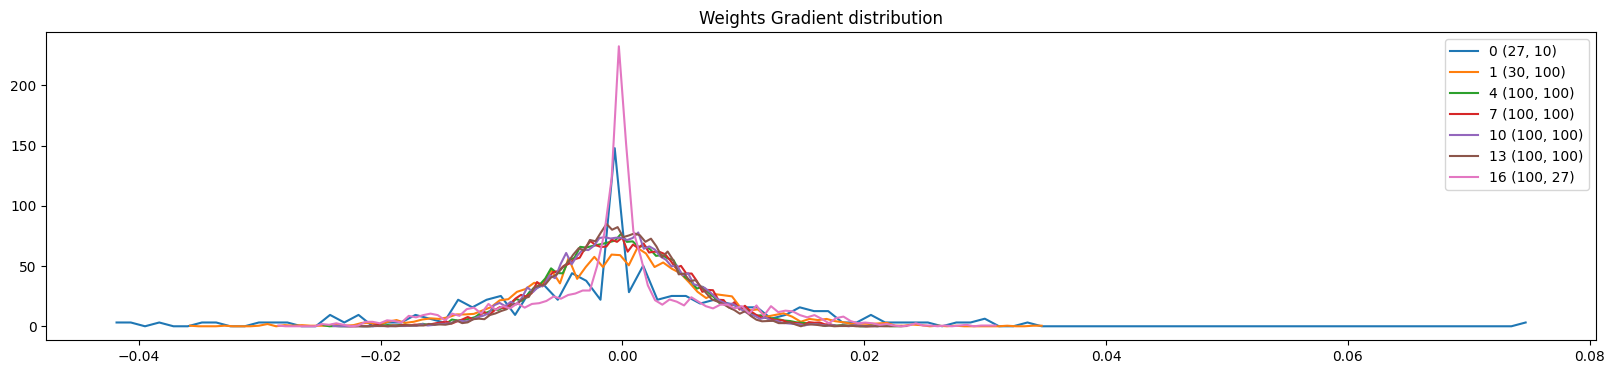

In [42]:
plt.figure(figsize=(20, 4))
legends = []
for i, p in enumerate(parameters):
    t = p.grad
    if p.ndim == 2:
        print(
            f"weight: {str(tuple(p.shape)):>15} | mean: {t.mean():>10.6f} | std: {t.std():>10.6e} | grad:data ratio: {t.std() / p.std():>10.6e}"
        )
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"{i} {str(tuple(p.shape))}")
plt.legend(legends)
plt.title("Weights Gradient distribution")

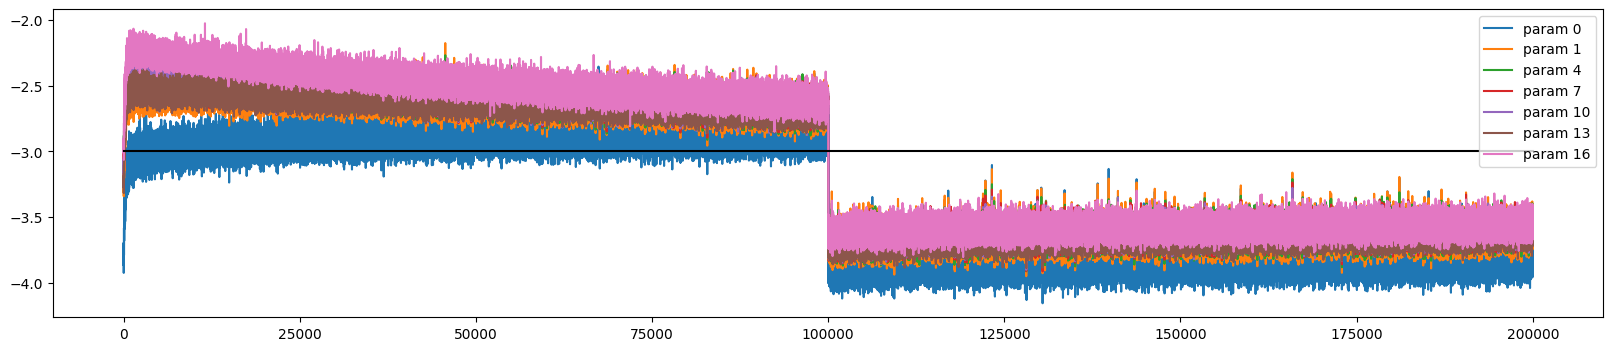

In [43]:
plt.figure(figsize=(20, 4))
legends = []
for i, p in enumerate(parameters):
    if p.ndim == 2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append("param %d" % i)
plt.plot(
    [0, len(ud)], [-3, -3], "k"
)  # these ratios should be ~1e-3, indicate on plot
plt.legend(legends)

In [44]:
@torch.no_grad()  # this decorator disables gradient tracking
def split_loss(split):
    x, y = {
        "train": (X_train, y_train),
        "val": (X_dev, y_dev),
        "test": (X_test, y_test),
    }[split]
    emb = C[x]  # (N, block_size, n_embd)
    x = emb.view(emb.shape[0], -1)  # concat into (N, block_size * n_embd)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, y)
    print(split, loss.item())


# put layers into eval mode
for layer in layers:
    layer.training = False
split_loss("train")
split_loss("val")

train 2.0146005153656006
val 2.087919235229492


In [45]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size  # initialize with all ...
    while True:
        # forward pass the neural net
        emb = C[torch.tensor([context])]  # (1,block_size,n_embd)
        x = emb.view(emb.shape[0], -1)  # concatenate the vectors
        for layer in layers:
            x = layer(x)
        logits = x
        probs = F.softmax(logits, dim=1)
        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        # if we sample the special '.' token, break
        if ix == 0:
            break

    print("".join(itos[i] for i in out))  # decode and print the generated word

montaymyah.
see.
mad.
ryla.
reiman.
ejdra.
grace.
kaitli.
jemilopareten.
estanaraelyzion.
kalin.
shubergiaghiel.
kendreelynn.
novana.
ubakard.
ruy.
juliek.
yuva.
myshonesshia.
salynn.
